In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
codes_cow_df = pd.read_csv("./data/religion/final_merged_country_data_v2.csv")[["Code", "CCode"]]
edi_df = (pd.read_csv("data/electoral-democracy-index.csv")
          .rename({"Electoral democracy index (best estimate, aggregate: average)": "edi"}, axis=1))
rel_df = pd.read_csv("data/religion/national_data.csv") # as found here: https://data.world/cow/world-religion-data
# import map here!
map_df = gpd.read_file('data/geodata/World_Countries.shp')
map_df = map_df.set_index('COUNTRY')

In [2]:
pd.options.mode.copy_on_write = True
main_rels = ["judgenpct", "islmgenpct", "chrstgenpct", "budgenpct",
            "hindgenpct", "sikhgenpct", "shntgenpct",
             "bahgenpct", "taogenpct", "confgenpct","anmgenpct"]
main_rels_abs = [rel[:-3] for rel in main_rels] # get "chrstgen" for "chrstgenpct"

main_rels_df = rel_df[["year", "state", "total", "nonreligpct", "othrgenpct"] + main_rels + main_rels_abs]

# Ensure all values in the main religion columns are numeric and replace NaNs with zeros
main_rels_df[main_rels] = main_rels_df[main_rels].apply(pd.to_numeric, errors='coerce').fillna(0)

# Replace NaNs in 'total' with 1 to avoid division by zero
main_rels_df['total'] = pd.to_numeric(main_rels_df['total'], errors='coerce').fillna(1)
main_rels_df[main_rels] = main_rels_df[main_rels].div(main_rels_df['total'], axis=0)
main_rels_df['primary_rel'] = main_rels_df[main_rels].idxmax(axis=1)
main_rels_df[main_rels] = main_rels_df[main_rels].apply(pd.to_numeric, errors='coerce')
main_rels_df[main_rels] = main_rels_df[main_rels].fillna(0)

# Define a function to calculate Shannon entropy
def calculate_entropy(row, main_rels):
    try:
        proportions = row[main_rels].values / 100  # Convert percentage values to proportions
        proportions = proportions[proportions > 0]  # Filter out zero proportions to avoid log(0)
        if len(proportions) == 0:
            return 0  # If no proportions are greater than zero, entropy is zero
        proportions = proportions.astype(float)  # Ensure all values are floats
        entropy = -np.sum(proportions * np.log2(proportions))  # Calculate entropy
        return entropy
    except Exception as e:
        print(f"Error calculating entropy for row: {row.name}, error: {e}")
        return np.nan

# Apply the entropy calculation to each row
main_rels_df['entropy'] = main_rels_df.apply(calculate_entropy, axis=1, main_rels=main_rels)

# Merge main religions, democracy index using the country code-translation
main_rels_df = main_rels_df.rename({"state":"CCode", "year": "Year"}, axis=1)
df1 = pd.merge(main_rels_df, codes_cow_df.drop_duplicates(), on="CCode", )
df2 = pd.merge(df1, edi_df, on=["Code", "Year"])
df = df2[["Code", "Entity", "Year","edi", "nonreligpct", "entropy", "primary_rel"] + main_rels_abs]
# 


In [3]:
cols = ["Code", "Entity", "Year"]
subset_map_entropy = df[cols + ["entropy"]]
subset_map_nonreligious = df[cols + ["nonreligpct"]]
subset_scatter_edi_entropy = df[cols + ["edi", "entropy"]]
subset_scatter_edi_nonreligious = df[cols + ["edi", "nonreligpct"]]

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_edi_map(edi_df, map_df, year, col="edi"):
    # Filter and clean the data
    edi_df = edi_df.set_index('Entity')
    edi_df = edi_df.dropna(how='all')
    edi_df = edi_df[edi_df['Year'] == year]
    
    # Merge the map data with the edi data
    edi_map_df = map_df.join(edi_df, how='left')
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    map_df.plot(color='grey', ax=ax)
    
    # Plot the data with the specified column and color map
    p = edi_map_df.plot(column=col, 
                        cmap='plasma', 
                        legend=False, 
                        ax=ax)
    
    ax.axis('off')
    ax.set_title(f'Electoral democracy index {year}')
    
    # Add color gradient legend in custom axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="10%", pad=0.1)
    
    # Use the ScalarMappable to ensure the colorbar matches the plot
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=edi_map_df[col].min(), vmax=edi_map_df[col].max()))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(col)

    plt.tight_layout()
    plt.show()


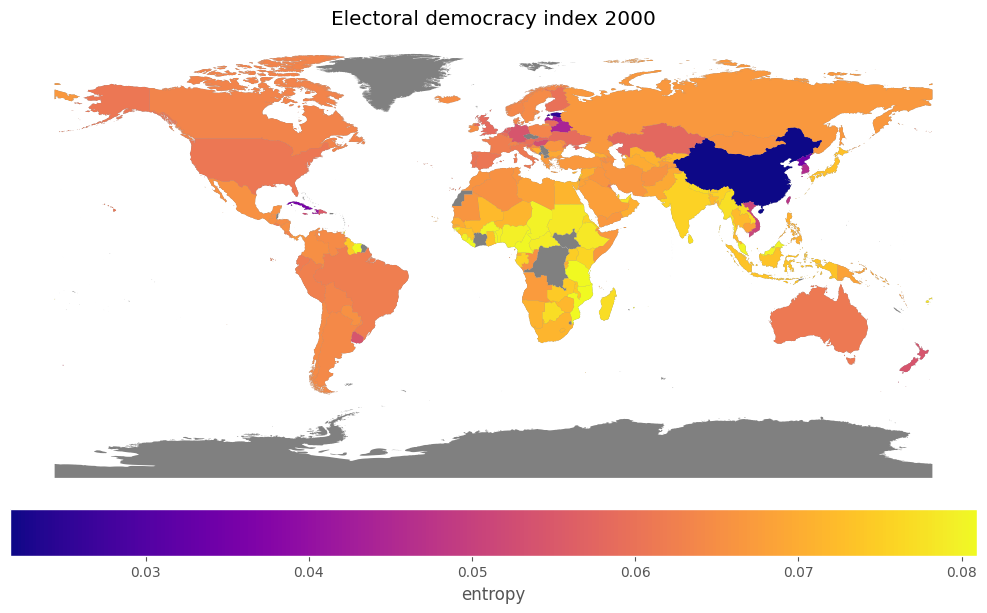

In [17]:
plot_edi_map(subset_map_entropy, map_df, 2000, col="entropy")

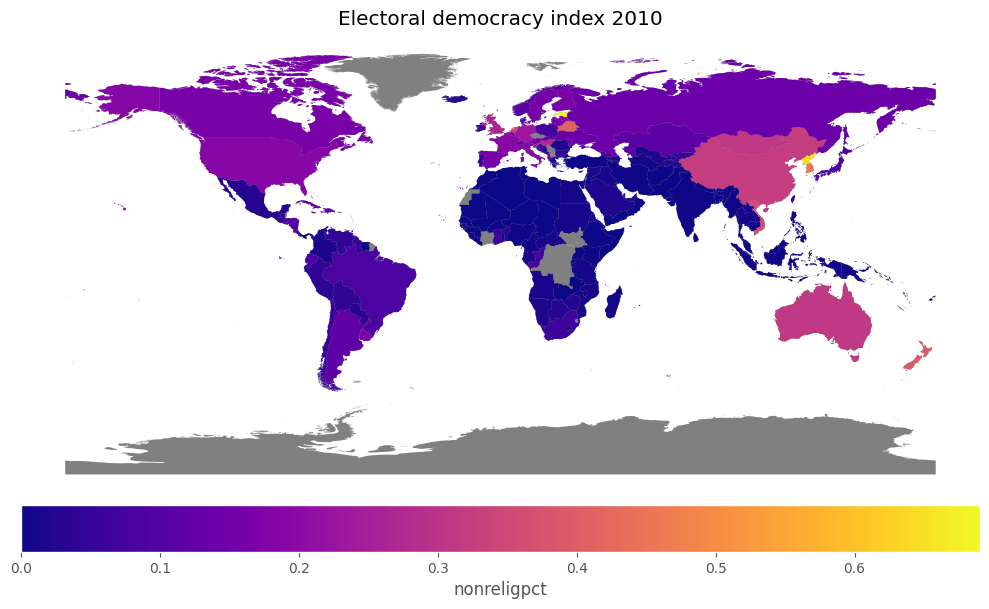

In [19]:
plot_edi_map(subset_map_nonreligious, map_df, 2010, col="nonreligpct")
